## Project 2
- Mike Ames 
- amesam@wfu.edu
- 18May2020

### Load Packages
-------



In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.tree import export_text                   #- export tree as text rules 
from sklearn import tree

# -- visualize decision trees and decision surfaces 
import graphviz 

# -- need this to render charts in notebook -- 
%matplotlib inline


## Tasks 
### Part 1
1. Stage data
2. Clean up column names 
3. Describe data 
4. Explore likely predictors  

### Part 2.
5. Partition into 75/25 split 
6. Train a decision tree model  
7. Evaluate Performance 

### Part 3.  
8. Write up your thoughts. 

# Part 1. 
## 1. Stage 
----- 
import our dataset into a pandas dataframe

In [2]:
df = pd.read_csv("./data/adult.csv", na_values="?")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


## 2.  Clean up Column Names

*It's just not fun dealing with ill-formed columns*

- remove leading and trailing characters
- replace spaces with underscores _ 
- change case to lower case
- remove various special characters

In [3]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


## 3. Describe data

### Check Target
-----

Always start by understanding your "target" value 


<div class="alert-success"> 💡  <strong> Comentary </strong>


- Below you can see that 24% are >50K earners, while 76% are <=50K, we also see that we have a good amount of records(48k) 
 
</div>


In [4]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [5]:
df['income'].value_counts(normalize=True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

### Describe 
---------
Always take a look at your data to see what you are dealing with 

<div class="alert-success"> 💡  <strong> Comentary </strong>


- below you can see that we have several categorical and numeric features.
 
</div>

In [6]:
df.describe(include='all').T.sort_values('unique')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,48842,2,Male,32650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,48842,2,<=50K,37155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,48842,5,White,41762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,48842,6,Husband,19716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workclass,46043,8,Private,33906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,46033,14,Prof-specialty,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
native_country,47985,41,United-States,43832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,48842,NaN,NaN,NaN,38.6436,13.7105,17,28,37,48,90


#### Check out Nulls 
----
Null values can be interesting but you have to deal with them when we get to building models. step 1 is to identify your problem areas. step 2 would be to figure out if there is any predictive power in the nulls, step 3. would be handle them. forturnately we are just going to deal with identifyin if we have any nulls. 

<div class="alert-success"> 💡  <strong> Comentary </strong>


- every column has some number of nulls, even the target. what do we do about them? 
 
</div>

In [7]:
# -- count nulls by column -- 
df.isnull().sum(axis = 0)

age                   0
workclass          2799
fnlwgt                0
education             0
educational_num       0
marital_status        0
occupation         2809
relationship          0
race                  0
gender                0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country      857
income                0
dtype: int64

## 4. Explore likely predictors 

----

<div class="alert-success"> 💡  <strong> Comentary </strong>


- I'm not planning on repeating the analysis here, instead i'll just show you that you can treat numeric varaibles as categorical and the pd.crosstab stunt works pretty good regardless of datatype. 
 
</div>


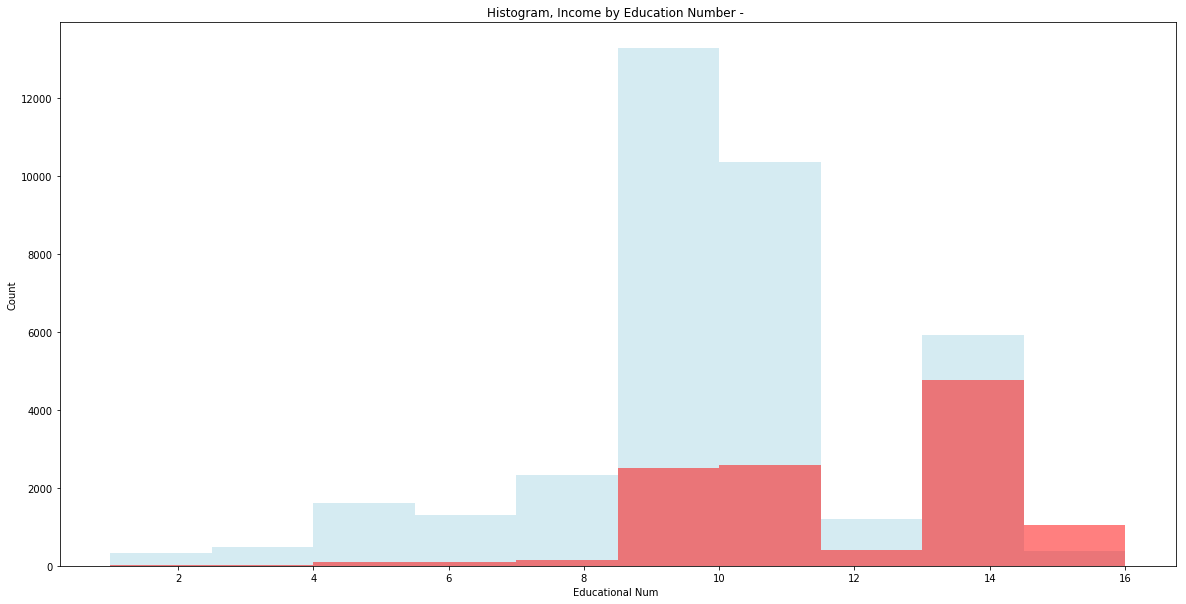

In [8]:
plt.figure(figsize=(20,10))

# -- divide my data into two datasets by target variable 
lt50 = df.loc[df['income'] == "<=50K"]
gt50 = df.loc[df['income'] == ">50K"]


# -- simply change the bin size to make the chart look better --
plt.hist(lt50['educational_num'], 10, facecolor='lightblue', alpha=0.5)
plt.hist(gt50['educational_num'], 10, facecolor='red', alpha=0.5)
plt.title('Histogram, Income by Education Number - ')
plt.ylabel('Count')
plt.xlabel('Educational Num ')
plt.show()

In [9]:
# -- normalize index converts to row percetages, see anything strange?  
ctab = pd.crosstab(df['educational_num'], df['income'], normalize="index").reset_index()
ctab

income,educational_num,<=50K,>50K
0,1,0.987952,0.012048
1,2,0.967611,0.032389
2,3,0.946955,0.053045
3,4,0.935079,0.064921
4,5,0.945767,0.054233
5,6,0.937365,0.062635
6,7,0.949227,0.050773
7,8,0.926941,0.073059
8,9,0.841422,0.158578
9,10,0.810351,0.189649


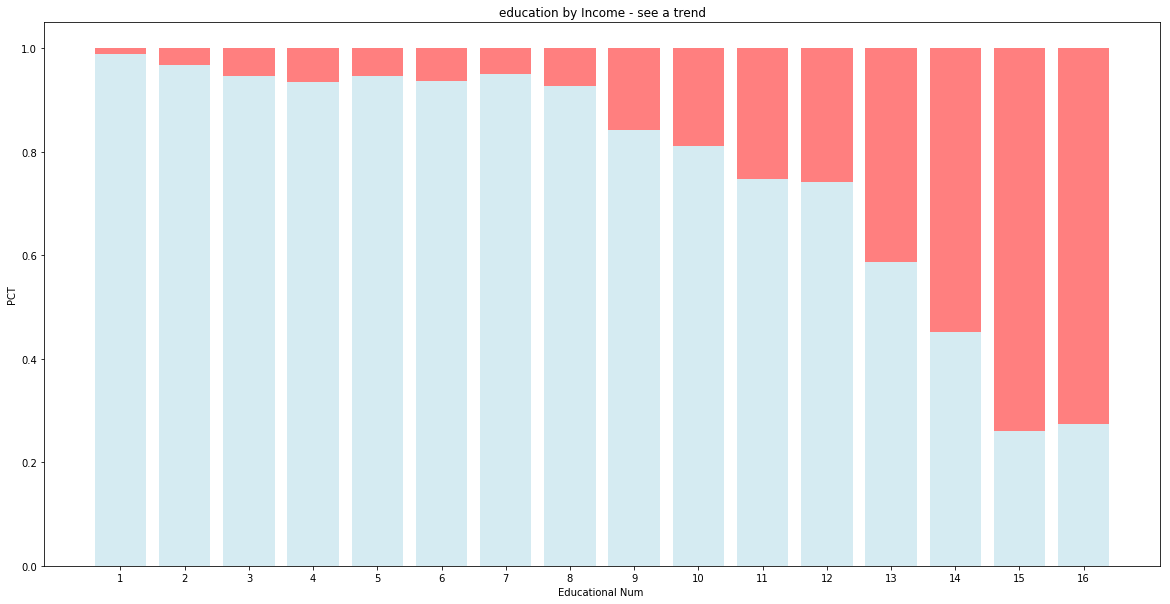

In [10]:
plt.figure(figsize=(20,10))
# -- check out bottom 
plt.bar(ctab['educational_num'].astype('str'), ctab['<=50K'], facecolor='lightblue', alpha=0.5)
plt.bar(ctab['educational_num'].astype('str'), ctab['>50K'], bottom=ctab['<=50K'], facecolor='red', alpha=0.5)
plt.title('education by Income - see a trend')
plt.ylabel('PCT')
plt.xlabel('Educational Num ')
plt.show()

### Say you have something like capital gains could you do the same thing? 

Sure pandas cut will slice a numeric variable into a number of bins. lets see it in action. 


<div class="alert-success"> 💡  <strong> Comentary </strong>

this is a common thing that happens. the distribution is quite skewed. but you really don't see the power of the cross tab until you visualize it normalized by bin, then there are clear ranges that you could pick out that separates high and low income.  
 
</div>

In [11]:
# -- normalize index converts to row percetages 
df['capital_gain_bin'] = pd.cut(df['capital_gain'],10).astype(str)
ctab = pd.crosstab(df['capital_gain_bin'], df['income'], ).reset_index()
ctab

income,capital_gain_bin,<=50K,>50K
0,"(-99.999, 9999.9]",37137,10571
1,"(19999.8, 29999.7]",1,127
2,"(29999.7, 39999.6]",6,0
3,"(39999.6, 49999.5]",3,0
4,"(89999.1, 99999.0]",0,244
5,"(9999.9, 19999.8]",8,745


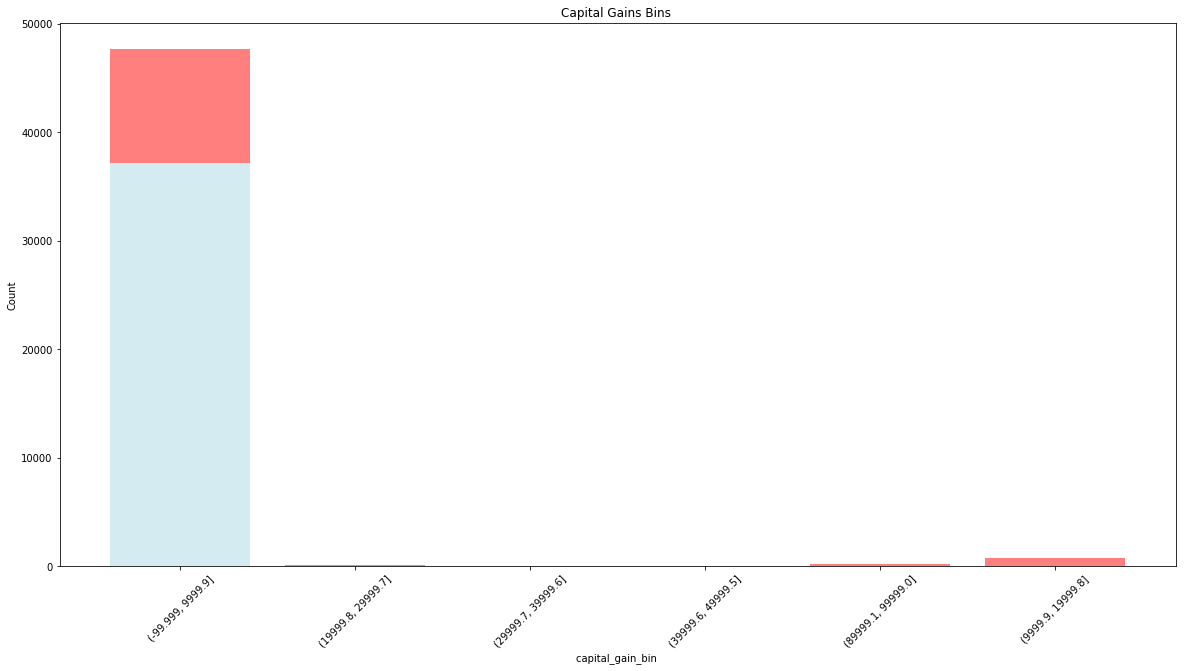

In [12]:
plt.figure(figsize=(20,10))
# -- check out bottom 
plt.bar(ctab['capital_gain_bin'].astype(str), ctab['<=50K'], facecolor='lightblue', alpha=0.5)
plt.bar(ctab['capital_gain_bin'].astype(str), ctab['>50K'], bottom=ctab['<=50K'], facecolor='red', alpha=0.5)
plt.xticks(rotation=45)
plt.title('Capital Gains Bins ')
plt.ylabel('Count')
plt.xlabel('capital_gain_bin ')
plt.show()

In [13]:
ctab = pd.crosstab(df['capital_gain_bin'], df['income'], normalize="index").reset_index()
ctab

income,capital_gain_bin,<=50K,>50K
0,"(-99.999, 9999.9]",0.778423,0.221577
1,"(19999.8, 29999.7]",0.007812,0.992188
2,"(29999.7, 39999.6]",1.000000,0.000000
3,"(39999.6, 49999.5]",1.000000,0.000000
4,"(89999.1, 99999.0]",0.000000,1.000000
5,"(9999.9, 19999.8]",0.010624,0.989376


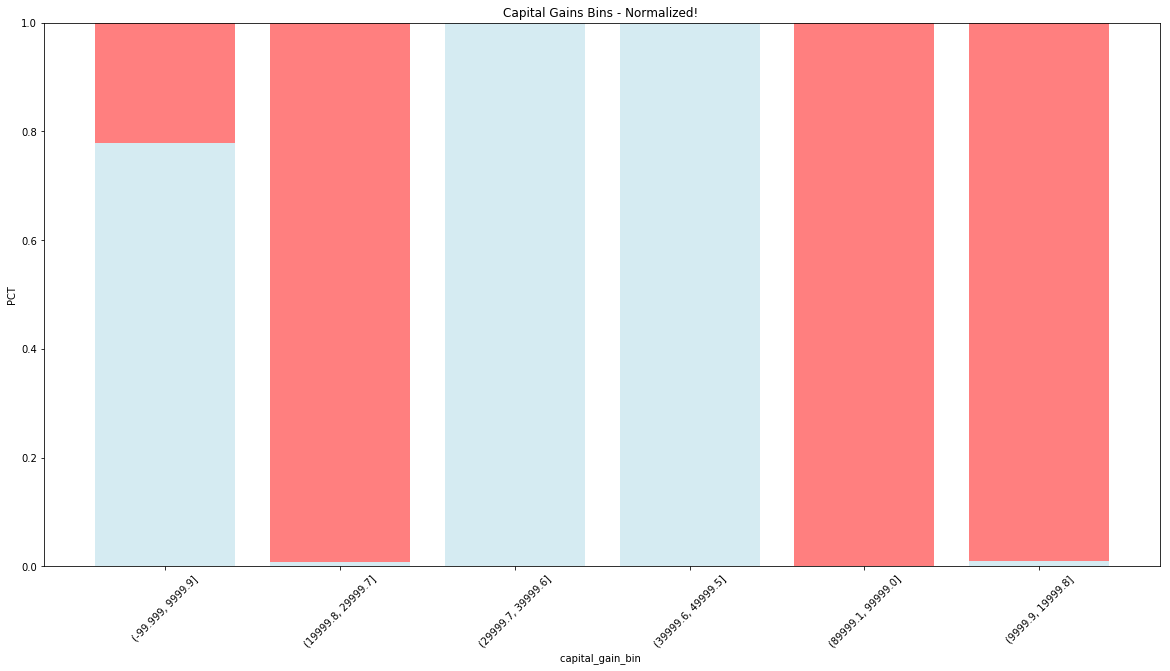

In [14]:
plt.figure(figsize=(20,10))
# -- check out bottom 
plt.bar(ctab['capital_gain_bin'].astype(str), ctab['<=50K'], facecolor='lightblue', alpha=0.5)
plt.bar(ctab['capital_gain_bin'].astype(str), ctab['>50K'], bottom=ctab['<=50K'], facecolor='red', alpha=0.5)
plt.xticks(rotation=45)
plt.title('Capital Gains Bins - Normalized! ')
plt.ylabel('PCT')
plt.xlabel('capital_gain_bin ')
plt.show()

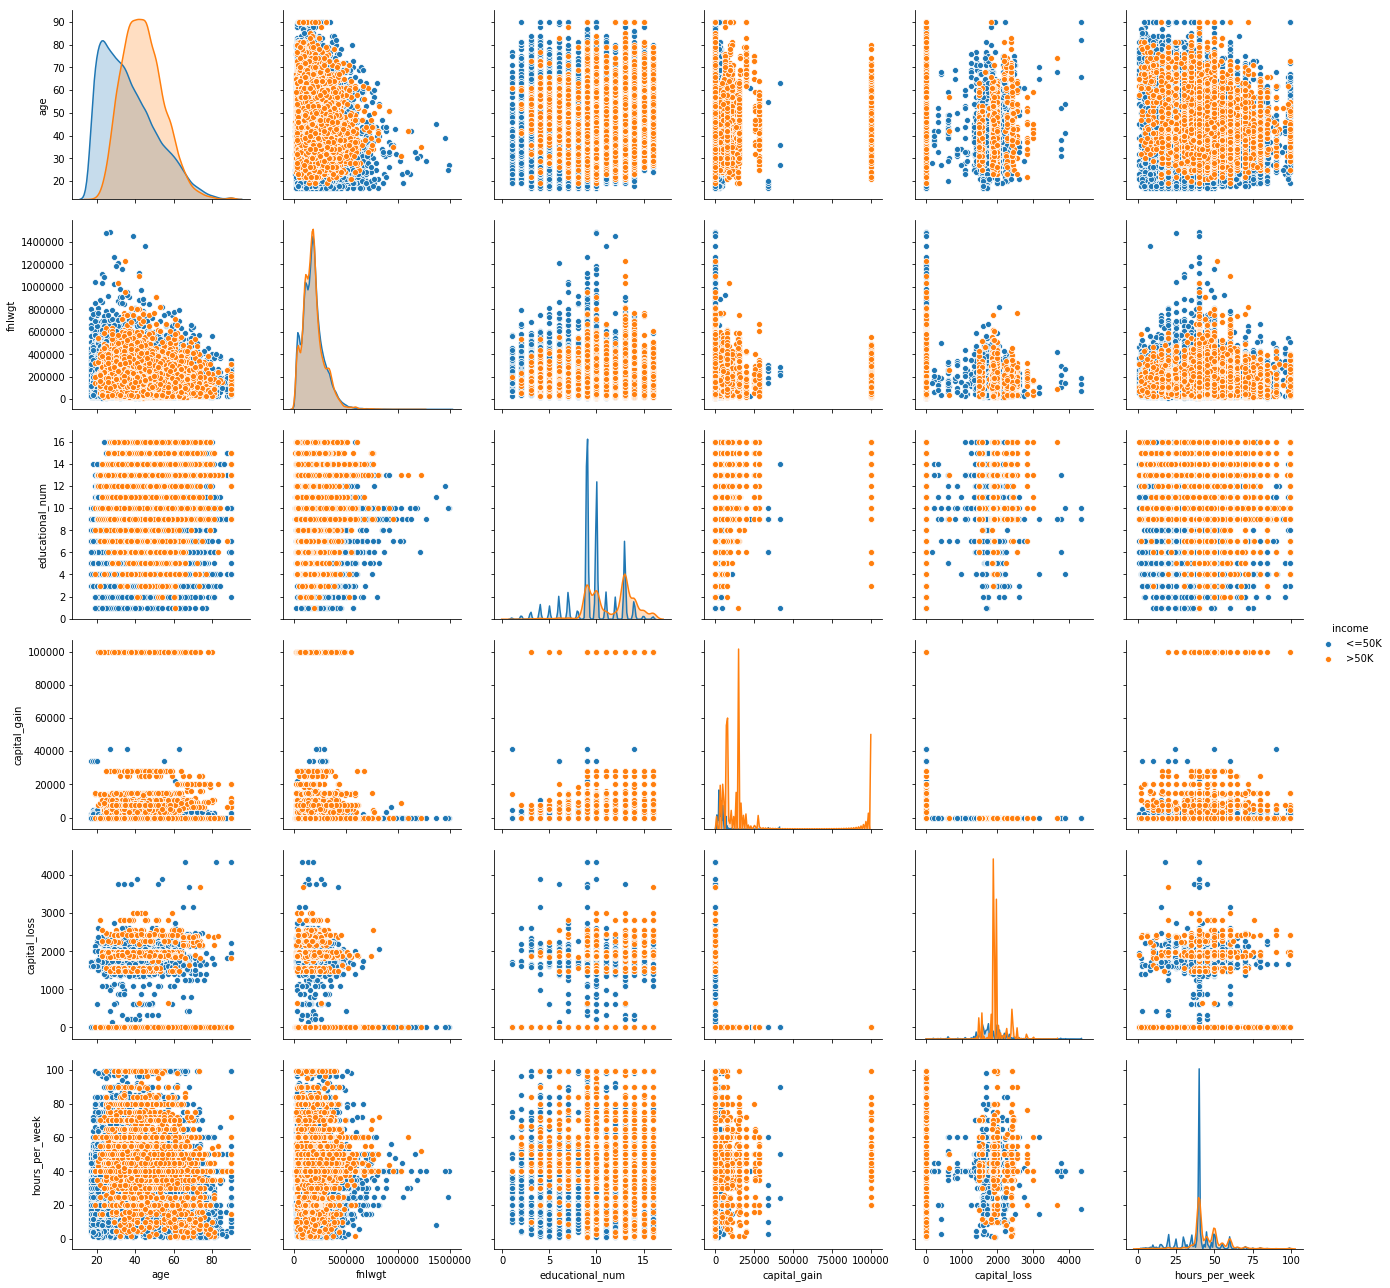

In [15]:
# -- 2uestion what does a pairs plot do? 
sns.pairplot(df, hue='income', height=3)

# Part 2.
## 5. Partition into 75/25 split 


In [16]:
## Convert income to a 0 / 1 
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64

In [17]:
train, test = train_test_split(df,test_size=0.30)

print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))


train pct: 70.00%
test  pct: 30.00%


## 6. Train a decision tree model  


### About Decision Trees

> scikit-learn version of Decision Trees uses an optimised version of the CART algorithm. 

The following are the key "hyper-parameters" used to influence training and tuning of a decision tree. 

-----

   #### criterion{“gini”, “entropy”}, default=”gini”
    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

   ####  splitter{“best”, “random”}, default=”best”
    The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

   #### max_depth, default=None
    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

   #### min_samples_split, default=2
    The minimum number of samples required to split an internal node:


## The Hard way with Pandas.  
---
Nulls known as NAs in Python and Categorical varaibles are a problem for all machine learning models. Some methods will handle them for you others not so much. We are going to learn to use sklearn pipelines to deal with nulls and all the transformation logic needed for both numeric and categorical variables, but first i'm gong to show you the manual way do deal with this, which is essentially write code. This way works but is not neat and tidy like the sklearn pipeline approach I'll outline below. 

the manual approach follows these steps: 

1. Split your features into categorical and numeric, Why? becaouse you need to handle each separately.  

2. Use pandas' fillna function to replace nulls 
    - numerics we'll code missing as -1, but we could replace missing with the mean, median, mode or some other value. 
    - character columns we'll replace missing with "missing", but we could replace it with mode or some other value as well. 

3. Use panda's get_dummies to create 0/1s for all categories in your dataset. 

4. Partition into training and Test

5. Train Tree

6. Evaluate 


In [18]:
# 1. Split features into categorical and numeric 
target = 'income'

numeric_features = ['age',
                    "fnlwgt", 
                    "educational_num",
                    "capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features = ["gender",
                        "relationship",
                        "marital_status",
                        "workclass",
                        "occupation",
                        "education"] 

In [19]:
df_prep = df.copy()

# 2. deal with nulls using fillna 
df_prep[numeric_features]     = df_prep[numeric_features].fillna(-1)
df_prep[categorical_features] = df_prep[categorical_features].astype('str').fillna('missing')
df_prep.isnull().sum(axis = 0)

age                   0
workclass             0
fnlwgt                0
education             0
educational_num       0
marital_status        0
occupation            0
relationship          0
race                  0
gender                0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country      857
income                0
capital_gain_bin      0
dtype: int64

In [20]:
#3. use get_dummies to turn categorical features into 0/1s 
y = df[target].values
df_prep = pd.get_dummies(df_prep[numeric_features+categorical_features],columns=categorical_features)
df_prep.columns

Index(['age', 'fnlwgt', 'educational_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'gender_Female', 'gender_Male',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'marital_status_Divorced', 'marital_status_Married-AF-spouse',
       'marital_status_Married-civ-spouse',
       'marital_status_Married-spouse-absent', 'marital_status_Never-married',
       'marital_status_Separated', 'marital_status_Widowed',
       'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'workclass_nan', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners

In [21]:
df_prep.head()


,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week,gender_Female,gender_Male,relationship_Husband,relationship_Not-in-family,...,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college
0,25,226802,7,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38,89814,9,0,0,50,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,28,336951,12,0,0,40,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,44,160323,10,7688,0,40,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,18,103497,10,0,0,30,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_prep,y, test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))

train pct: 70.00%
test  pct: 30.00%


In [23]:
dtree = tree.DecisionTreeClassifier(
                                    criterion='gini',
                                    max_depth=10,
                                    min_samples_leaf=10)
dtree = dtree.fit(X_train, y_train)
dtree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

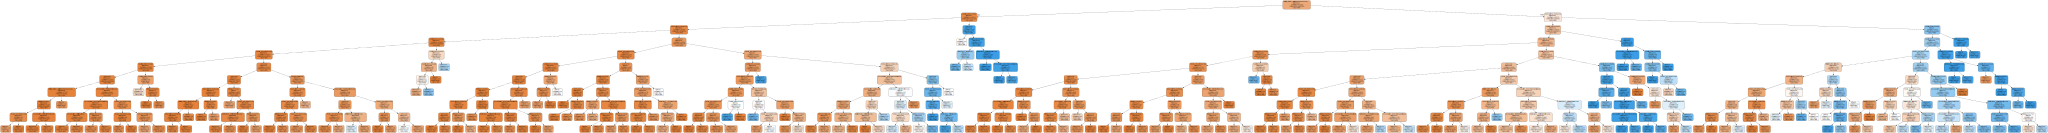

In [24]:
dot_data = tree.export_graphviz(dtree, out_file=None, 
                      feature_names=X_train.columns, 
                        class_names = ["low", "high"],
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

### Build a Pipeline 
-------
Why a pipeline? most ML models can't or won't explicitly handle string data we have to convert it to a number. 

What are my options. Well there are two options.
1. manually deal with missing values, pd.fillna will do the job 
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html 
2. mannually create 0/1s,  pd.get_dummies will do that too 
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
    
The problem is that this works for academic datasets but doesn't work in the real-world. in the real-world data is messy what happens when you get a new level in one of your categorical variables, more hand coding. No manually dealing with missing values and categorical varaibles is a lot fo work for very little gain. The best pratice is to use a pipeline! 





In [25]:
# -- we need this to make our pipeline 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

## Create our Pipeline 



In [26]:
# 1. Split features into categorical and numeric 
target = 'income'

numeric_features = ['age',
                    "fnlwgt", 
                    "educational_num",
                    "capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features = ["gender",
                        "relationship",
                        "marital_status",
                        "workclass",
                        "occupation",
                        "education"] 

In [27]:
# -- this is your pipeline based model -- 
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

decision_tree = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', DecisionTreeClassifier(max_depth = 10,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                          random_state=42))
])

decision_tree = decision_tree.fit(train[categorical_features + numeric_features], train[target])
decision_tree

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

### Extract Transformed Feature Names, 

this just makes life easier... we need to get the new feature names from the transformed data specifically from the categorical transformer. Since we use onehot encoding we turn all categories into new columns with 0/1s. 

In [28]:
# 1. Split features into categorical and numeric 
target = 'income'

numeric_features2 = ['age',
                    "fnlwgt", 
                    "educational_num",
                    #"capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features2 = ["gender",
                        "relationship",
                        #"marital_status",
                        "workclass",
                        "occupation",
                        "education"] 

In [29]:
# -- this is your pipeline based model -- 
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features2),
    ('num', numerical_pipe, numeric_features2)
    ])

decision_tree2 = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', DecisionTreeClassifier(max_depth = 10,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                          random_state=42))
])

decision_tree2 = decision_tree2.fit(train[categorical_features2 + numeric_features2], train[target])
decision_tree2

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [30]:
predict_1 = decision_tree.fit(test[categorical_features + numeric_features])
predict_2 = decision_tree2.fit(test[categorical_features2 + numeric_features2])

TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

In [ ]:
# -- get the feature names from the transform, remember we've now made a number of new columns by doing one-hot-encoding --
categorical_pipe.fit_transform(train[categorical_features])
transformed_categorical = categorical_pipe['onehot'].get_feature_names(categorical_features).tolist()

# -- creates one list of all the feature names. 
feature_names =  transformed_categorical + numeric_features


### We can Visualize our Decision Tree using graphviz 

In [ ]:
# -- chart of tree 
import graphviz 
dot_data = tree.export_graphviz(decision_tree['classifier'], 
                                out_file=None,
            feature_names = feature_names,
            class_names=["low", "high"],
            max_depth = 3,
            filled=True, 
            rounded=True,  
            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

#### We can also get a list of rules from our tree, this is usful for interpreting what the model is doing

In [ ]:
# -- Text based Rules for your Tree 
r = export_text(decision_tree['classifier'], 
                feature_names= feature_names)
print(r)

## useful python trick... 

```python
for counter, value in enumerate(some_list):
    print(counter, value)
```

In [ ]:

# -- get feature importance 
importance = decision_tree['classifier'].feature_importances_

# -- summarize feature importance into a dictionary 
feature_imp ={}
for i,v in enumerate(importance):
    feature_imp[feature_names[i]] = v

# make the dictionary a data frame 
feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                     columns=['importance'])

# -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
feature_imp = (feature_imp
               .reset_index()
               .rename(columns={'index':'feature'})
               .sort_values('importance',ascending=False)
               .query('importance > 0.01'))

# -- plot that 
plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
plt.title('Decision Tree Variable Iportance')
plt.ylabel('Feature')
plt.xlabel('Importance ')
plt.xticks(rotation=45)
plt.show()




##  Evaluate Performance 
-----

Here we want to compare the accuracy and confusion matrix of our decision tree pipeline on both our training data and test data. Sklearn provides two convient function to apply our models 

    .predict() - predicts the "label" or "target" on a new data set. This method accepts one argument, the new data set (e.g. model. predict(X_new) ), and returns the learned label for row. in our case it will return a 1 for income >50K and a 0 for <=50K
    
    .predict_proba() -  gives us the probabilities for the target (0 and 1) in array form. The number of probabilities for each row is equal to the number of categories in target variable. 
    
-----
1. Apply to training data 
2. Apply to testing data
3. Compare accuracy and confusion matrix 


In [ ]:
train['income_pred'] = decision_tree.predict(train[numeric_features + categorical_features])
train_probabilites = decision_tree.predict_proba(train[numeric_features + categorical_features])
train['income_p0'] = train_probabilites[:,0]
train['income_p1'] = train_probabilites[:,1]
train.head()

In [ ]:
test['income_pred'] = decision_tree.predict(test[numeric_features + categorical_features])
test_probabilites = decision_tree.predict_proba(test[numeric_features + categorical_features])
test['income_p0'] = test_probabilites[:,0]
test['income_p1'] = test_probabilites[:,1]
test.head()

In [ ]:
print("Training confusion Matrix")
confusion_matrix = pd.crosstab(train['income'], train['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_pct = pd.crosstab(train['income'], train['income_pred'], normalize="all", rownames=['Actual'], colnames=['Predicted']).round(3)
print (confusion_matrix)

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.title('Training confusion Matrix - Counts ')

plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix_pct, annot=True, fmt='g')
plt.title('Training confusion Matrix - PCTs ')
plt.show()

In [ ]:
print("Test confusion Matrix")
confusion_matrix = pd.crosstab(test['income'], test['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_pct = pd.crosstab(test['income'], test['income_pred'], normalize="all",  rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.title('Testing confusion Matrix - Counts ')
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix_pct, annot=True, fmt='g')
plt.title('Testing confusion Matrix - PCTs ')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
### Default Accuracy, i.e. do nothing predict everyone as <50K, is the same as saying what % of <50K 
accuracy_default = train['income'].value_counts(normalize='True')[0]
accuracy_train = accuracy_score(train['income'], train['income_pred'])
accuracy_test = accuracy_score(test['income'], test['income_pred'])
print("Default Accuracy : {:2.2%}".format(accuracy_default))
print("Train Accuracy   : {:2.2%}".format(accuracy_train))
print("Test Accuracy    : {:2.2%}".format(accuracy_test))

## 8. Thoughts


<div class="alert-success"> 💡  <strong> Comentary </strong>

Well our decison tree is a lot more accurate than our rule, if we looked at our rule from the previous project we had a accuracy of 53% on both training and test, which is much worse than just doing nothing (76% accurate). Here we are 87% accurate on the trainig set and 85.5% on the test set, significantly better at predicting income. 

Key things to note:  
1. tree depth plays a big role in a tree's abilty to predict 
2. based on the analysis below, by removing the marital_status(the first split feature) we get similar performance? whats going on? 
3. marital_status and relationship appear to have similar importance 

I wonder how we can take advantage of this feature of decision trees to improve their performance? 

</div>


In [ ]:
# -- remove marital_status and retrain 
target = 'income'

numeric_features = ['age',
                    "fnlwgt", 
                    "educational_num",
                    "capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features = ["gender",
                        "relationship",
                        #"marital_status",
                        "workclass",
                        "occupation",
                        "education"] 


In [ ]:
# -- this is your pipeline based model -- 
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

decision_tree = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', DecisionTreeClassifier(max_depth = 10,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                          random_state=42))
])

decision_tree2 = decision_tree.fit(train[categorical_features + numeric_features], train[target])
decision_tree2

In [ ]:
train['income_pred'] = decision_tree2.predict(train[numeric_features + categorical_features])
train_probabilites = decision_tree2.predict_proba(train[numeric_features + categorical_features])
train['income_p0'] = train_probabilites[:,0]
train['income_p1'] = train_probabilites[:,1]

test['income_pred'] = decision_tree2.predict(test[numeric_features + categorical_features])
test_probabilites = decision_tree2.predict_proba(test[numeric_features + categorical_features])
test['income_p0'] = test_probabilites[:,0]
test['income_p1'] = test_probabilites[:,1]


accuracy_default = train['income'].value_counts(normalize='True')[0]
accuracy_train = accuracy_score(train['income'], train['income_pred'])
accuracy_test = accuracy_score(test['income'], test['income_pred'])
print("Default Accuracy : {:2.2%}".format(accuracy_default))
print("Train Accuracy   : {:2.2%}".format(accuracy_train))
print("Test Accuracy    : {:2.2%}".format(accuracy_test))

In [ ]:
# -- gets the feature names 
categorical_pipe.fit_transform(train[categorical_features])
transformed_categorical = categorical_pipe['onehot'].get_feature_names(categorical_features).tolist()

# -- creates one list of all the feature names. 
feature_names =  transformed_categorical + numeric_features

In [ ]:

# -- get feature importance 
importance = decision_tree2['classifier'].feature_importances_

# -- summarize feature importance into a dictionary 
feature_imp ={}
for i,v in enumerate(importance):
    feature_imp[feature_names[i]] = v

# make the dictionary a data frame 
feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                     columns=['importance'])

# -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
feature_imp = (feature_imp
               .reset_index()
               .rename(columns={'index':'feature'})
               .sort_values('importance',ascending=False)
               .query('importance > 0.01'))

# -- plot that 
plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
plt.title('Decision Tree Variable Iportance')
plt.ylabel('Feature')
plt.xlabel('Importance ')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 〖−𝑝〗_𝑐𝑙𝑎𝑠𝑠0∗log⁡(𝑝_𝑐𝑙𝑎𝑠𝑠0) - 𝑝_𝑐𝑙𝑎𝑠𝑠1∗log⁡(𝑝_𝑐𝑙𝑎𝑠𝑠1)

df_gini = pd.DataFrame(np.linspace(0,1,11), columns=['P0'])
df_gini["P1"] = 1 - df_gini["P0"]
df_gini["ginix"] = 2*df_gini["P1"]*df_gini["P0"]
df_gini["entropy"] = -df_gini["P0"]*np.log2(df_gini["P0"]) - df_gini["P1"]*np.log2(df_gini["P1"]) 
df_gini = df_gini.fillna(0) 
df_gini

In [ ]:
sns.lineplot("P0", y='ginix', data=df_gini)
sns.lineplot("P0", y='entropy', data=df_gini)

In [ ]:
plt.figure(figsize=(5,10))
plt.plot(df_gini["P1"],df_gini['ginix'])
plt.axhline(y=0.5,color='r',linestyle='--')
plt.title('Gini Impurity Graph')
plt.xlabel('P1=1')
plt.ylabel('Impurity Measure')
plt.ylim([0,1])
plt.show()

In [ ]:
plt.figure(figsize=(7,10))
plt.plot(df_gini["P1"],df_gini['entropy'])
plt.axhline(y=1,color='r',linestyle='--')
plt.title('Entropy Impurity Graph')
plt.xlabel('P1=1')
plt.ylabel('Impurity Measure')
plt.ylim([0,1.1])
plt.show()